In [1]:
import tifffile as tiff
from octvision3d.utils import get_filenames
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import seaborn as sns
from sklearn.metrics import confusion_matrix
from tqdm import tqdm

In [2]:
# Function to convert hex to RGB
def hex_to_rgb(hex_color):
    hex_color = hex_color.lstrip('#')
    return tuple(int(hex_color[i:i+2], 16) for i in (0, 2, 4))

In [3]:
path = "/data/dkermany_data/OCT/nnUNet_raw/Dataset006_OCTAVEv6/imagesTr"
label_path = "/data/dkermany_data/OCT/nnUNet_raw/Dataset006_OCTAVEv6/labelsTr"
pred_path = "/data/dkermany_data/OCT/nnUNet_results/Dataset006_OCTAVEv6/CustomNNUNetTrainer2__nnUNetPlans__2d/crossval_results_folds_0_1_2_3_4"
dataset = "CrossVal_nnUNet"

color_map = {
    1: "#f1d691",  # SRM
    2: "#b17a65",  # HRM
    3: "#6fb8d2",  # FLU
    4: "#d8654f",  # HTD
    5: "#90ee90",  # RPE
    6: "#a200ff",  # RET
    7: "#8f8f70",  # CHO
    8: "#e1f0fd", # VIT
    9: "#75fafd", # HYA
    10: "#FBFFCB", # SHS
    11: "#fdfd54", # ART
    12: "#387df8", # ERM
    13: "#643200", # SES
}

label_map = {
    1: "SRM",
    2: "HRM",
    3: "FLU",
    4: "HTD",
    5: "RPE",
    6: "RET",
    7: "CHO",
    8: "VIT",
    9: "HYA",
    10: "RHS",
    11: "ART",
    12: "ERM",
    13: "SES"
}

save_output = True
plot_individual = False
plot_all_slices = False

In [4]:
def plot_confusion_matrix(true_labels_flat, pred_labels_flat, label_map, save=False, suffix="", ignore_labels=[], tick_labels=True):
    """
    Plot a normalized confusion matrix with reordered labels and optional saving.

    Parameters:
    - true_labels_flat: np.ndarray, ground truth labels (1D array of class integers)
    - pred_labels_flat: np.ndarray, predicted labels (1D array of class integers)
    - label_map: dict, mapping from label indices to human-readable class names
    - save: bool, if True, saves the confusion matrix to ~/Downloads as an SVG file
    - suffix: str, suffix to append to saved filename and plot title (used only if save is True or title is desired)
    - ignore_labels: list, label indices to exclude from the confusion matrix
    - tick_labels: bool, whether to display axis tick labels (class names)

    Returns:
    - None. Displays (and optionally saves) a seaborn heatmap of the normalized confusion matrix.
    """
    # Define the new order for labels
    new_order = [7, 8, 6, 5, 9, 10, 12, 13, 3, 2, 1, 4, 11]
    
    # Create a mapping dictionary from old labels to new indices based on new_order
    label_mapping = {old: new for new, old in enumerate(new_order)}

    print("Starting")
    # Create a mapping array (lookup table) based on new_order
    max_label = max(label_mapping.keys()) + 1  # Size of lookup table
    lookup_table = np.zeros(max_label, dtype=int)
    
    for old_label, new_label in tqdm(label_mapping.items()):
        lookup_table[old_label] = new_label
    
    # Apply the mapping using the lookup table
    true_labels_mapped = lookup_table[true_labels_flat]
    pred_labels_mapped = lookup_table[pred_labels_flat]
    print("Finished lookup table")
    
    # Re-map the labels using NumPy's vectorized operations
    # true_labels_mapped = np.array([label_mapping[label] for label in tqdm(true_labels_flat)])
    # pred_labels_mapped = np.array([label_mapping[label] for label in tqdm(pred_labels_flat)])
    
    # Use NumPy's isin to filter out ignored labels
    mask_true = ~np.isin(true_labels_mapped, ignore_labels)
    mask_pred = ~np.isin(pred_labels_mapped, ignore_labels)
    
    true_labels_mapped = true_labels_mapped[mask_true & mask_pred]
    pred_labels_mapped = pred_labels_mapped[mask_true & mask_pred]

    print("finished mapping")
    
    # Identify which labels are actually used
    # used_labels = np.unique(np.concatenate((true_labels_mapped, pred_labels_mapped)))
    used_labels = np.unique(true_labels_mapped)

    print("started confusion matrix calculations")
    # Compute the confusion matrix using only the used labels
    conf_matrix = confusion_matrix(true_labels_mapped, pred_labels_mapped, labels=used_labels)

    # Normalize the confusion matrix by row (i.e., by the sum of true labels in each row)
    row_sums = conf_matrix.sum(axis=1, keepdims=True)
    conf_matrix_normalized = np.divide(conf_matrix, row_sums, where=row_sums != 0)

    # Define a custom function for formatting annotations
    def annotate_fmt(val):
        if val < 0.01:
            return "0"
        return f"{val:.2f}"

    # Create a 2D array of formatted strings
    annot = np.array([[annotate_fmt(cell) for cell in row] for row in conf_matrix_normalized])

    # Use the used labels to extract correct tick labels
    reordered_labels = [label_map[new_order[label]] for label in used_labels]

    fontsize=12
    if tick_labels:
        tick_labels = reordered_labels
    else:
        tick_labels = []
    
    # Plot the confusion matrix using seaborn's heatmap
    print("Starting heatmap plotting")
    plt.figure(figsize=(9, 9))
    sns.heatmap(
        conf_matrix_normalized,
        annot=annot,
        fmt="",
        cmap="Blues",
        xticklabels=tick_labels,
        yticklabels=tick_labels,
        cbar=False,
        annot_kws={"fontsize": fontsize}  # Change font size for annotations
    )

    # Add labels and title
    if tick_labels:
        plt.xlabel('Predicted Labels', fontsize=fontsize)
        plt.ylabel('True Labels', fontsize=fontsize)
        plt.title(suffix)

    # Adjust font size for tick labels
    plt.xticks(fontsize=fontsize)  # X-axis tick labels
    plt.yticks(fontsize=fontsize)  # Y-axis tick labels

    # Save the plot as an SVG file
    if save:
        if len(suffix) > 0:
            suffix = f"_{suffix}"
        output_path = os.path.join(os.path.expanduser("~"), "Downloads", f"confusion_matrix{suffix}.svg")
        
        plt.tight_layout()
        # plt.savefig(output_path, format="svg", bbox_inches="tight")
    
    # Show the plot
    plt.show()


In [5]:
true_labels_all = []
pred_labels_all = []


# for f in get_filenames(path, "tif"):
files = [i for i in get_filenames(path, "tif") if "NORMAL_" in i or "ERM_" in i]
for f in tqdm(files):
    pred_f = os.path.join(pred_path, "_".join(os.path.basename(f).split("_")[:-1])+".tif")
    label_f = os.path.join(label_path, "_".join(os.path.basename(f).split("_")[:-1])+".tif")

    pred = tiff.imread(pred_f)
    orig = tiff.imread(f)
    label = tiff.imread(label_f)

    unique_values, counts = np.unique(label, return_counts=True)
    unique_values, counts = np.unique(label, return_counts=True)

    # Flatten the 3D arrays to 1D
    true_labels_flat = label.flatten()
    pred_labels_flat = pred.flatten()
    true_labels_all.append(true_labels_flat)
    pred_labels_all.append(pred_labels_flat)

    
    # Create an empty color image with shape (z, y, x, 3) for RGB channels
    z, y, x = orig.shape
    color_pred = np.zeros((z, y, x, 3), dtype=np.uint8)
    color_label = np.zeros((z, y, x, 3), dtype=np.uint8)

    # Map the grayscale image to the color image
    for grayscale_value, hex_color in color_map.items():
        rgb_color = hex_to_rgb(hex_color)
        color_pred[pred == grayscale_value] = rgb_color
        color_label[label == grayscale_value] = rgb_color

    if plot_individual:
        print(f)
        if not plot_all_slices:
            f, ax = plt.subplots(1,3, figsize=(26,8))
            ax[2].axis("off")
            ax[2].imshow(color_pred[9])
            ax[2].title.set_text("Prediction")
            ax[1].axis("off")
            ax[1].imshow(color_label[9])
            ax[1].title.set_text("Label")
            ax[0].axis("off")
            ax[0].imshow(orig[9], cmap="gray")
            ax[0].title.set_text("Original")
            plt.tight_layout()
            plt.show()
        else:
            for i in range(orig.shape[0]):
            # for i in range(5, 14):
                f, ax = plt.subplots(1,3, figsize=(52,16))
                ax[2].axis("off")
                ax[2].imshow(color_pred[i])
                # ax[2].title.set_text("Prediction")
                ax[1].axis("off")
                ax[1].imshow(color_label[i])
                # ax[1].title.set_text("Label")
                ax[0].axis("off")
                ax[0].imshow(orig[i], cmap="gray")
                # ax[0].title.set_text("Original")
                plt.tight_layout()
                plt.show()
        

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 120/120 [01:54<00:00,  1.05it/s]


In [6]:
# Concatenate all flattened labels and predictions into 1D arrays
true_labels_all = np.concatenate(true_labels_all)
pred_labels_all = np.concatenate(pred_labels_all)

Starting


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████| 13/13 [00:00<00:00, 363506.35it/s]


Finished lookup table
finished mapping
started confusion matrix calculations
Starting heatmap plotting


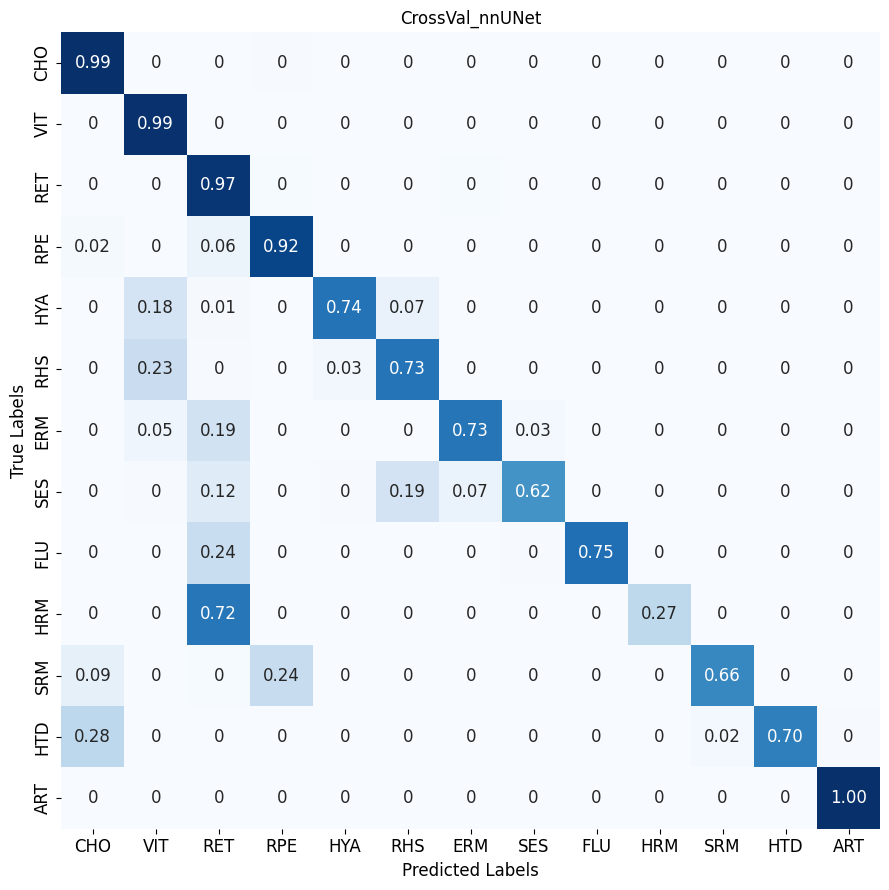

In [7]:
plot_confusion_matrix(true_labels_all, pred_labels_all, label_map, save=save_output, suffix=f"{dataset}", ignore_labels=[], tick_labels=True)

In [8]:
def calculate_dice_scores(labels, predictions, num_classes):
    """
    Calculate Dice scores for each label and the total Dice scores.

    Parameters:
    - labels: np.ndarray, ground truth segmentation labels (flattened)
    - predictions: np.ndarray, predicted segmentation labels (flattened)
    - num_classes: int, total number of classes/labels

    Returns:
    - dice_scores: dict, Dice score for each label (class)
    - total_dice_score: float, overall Dice score (weighted by instance counts)
    - average_dice_score: float, average of individual Dice scores
    """
    dice_scores = {}
    total_intersection = 0
    total_union = 0

    for cls in range(num_classes):
        # Binary masks for the current class
        label_mask = (labels == cls)
        prediction_mask = (predictions == cls)

        # Calculate intersection and union
        intersection = np.sum(label_mask & prediction_mask)
        union = np.sum(label_mask) + np.sum(prediction_mask)

        # Calculate Dice score for the current class
        if union == 0:
            dice_scores[cls] = 0.0  # Perfect score if there are no instances
        else:
            dice_scores[cls] = 2 * intersection / union

        # Update totals for overall Dice score
        total_intersection += intersection
        total_union += union

    # Calculate total Dice score (weighted by instance counts)
    if total_union == 0:
        total_dice_score = 0.0  # Perfect score if there are no instances
    else:
        total_dice_score = 2 * total_intersection / total_union

    # Calculate average Dice score
    average_dice_score = np.mean(list(dice_scores.values()))

    return dice_scores, total_dice_score, average_dice_score

In [9]:
from pprint import pprint

num_classes = 14

# Call the function
dice_scores, total_dice_score, average_dice_score = calculate_dice_scores(true_labels_all, pred_labels_all, num_classes)

# Output the results
print("Dice scores for each label:")  # A dictionary with Dice scores for each label
pprint(dice_scores)
print("Total Dice score:", total_dice_score)      # Weighted overall Dice score
print("Mean Dice score:", average_dice_score)    # Average of individual Dice scores

Dice scores for each label:
{0: 0.0,
 1: 0.059963469505947345,
 2: 0.061334061334061336,
 3: 0.5396803038454163,
 4: 0.06736355113163406,
 5: 0.8447078496991614,
 6: 0.9791688114667451,
 7: 0.9965721608153887,
 8: 0.9895640506511156,
 9: 0.649174683777513,
 10: 0.7730855379731442,
 11: 0.9921235703225861,
 12: 0.6679783678383724,
 13: 0.6018383631515901}
Total Dice score: 0.9848698858484228
Mean Dice score: 0.5873253415366196
